# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

/Users/hwijongim/Desktop/Github/P2502_HSC/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Parameters 
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'
p_type = 'FMB'

## ***Load Dataset***
---

In [3]:
### Load Raw Data 
# Data Import 
log_df, qa_df, recipe_df, info, weather_df = import_raw_data(path) 
recipe_origin_df = recipe_df.copy() 

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (9478081, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [4]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (8566802, 39)
Log Train Dataset: (128985, 18)


In [5]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 14)


In [6]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [7]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)

Daset Shape: (128985, 35)


In [8]:
### Get Cluster Column 
dataset = create_cluster_col(df3, p_type)  

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (101787, 36)


In [9]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B_결과", "M/B_기준",
    "Scorch_결과", "Vm_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time    101440
Ct 90_결과       59336
M/B_결과             0
M/B_기준             0
Scorch_결과      15154
Vm_결과          39284
경도_결과          69844
dtype: int64


## ***MODELLING***
---

In [10]:
### Train Test Split 
# Targets 
targets = ['cycle time','Ct 90_결과','Scorch_결과','Vm_결과','경도_결과']

# Cycle Time 
cycle_train_dataset, cycle_test_dataset, cycle_scaler, cycle_scaler_cols = create_train_test_dataset(dataset, targets[0], p_type)

# CT90 
ct_train_dataset, ct_test_dataset, ct_scaler, ct_scaler_cols = create_train_test_dataset(dataset, targets[1], p_type)

# Scorch
sc_train_dataset, sc_test_dataset, sc_scaler, sc_scaler_cols = create_train_test_dataset(dataset, targets[2], p_type)

# Vm 
vm_train_dataset, vm_test_dataset, vm_scaler, vm_scaler_cols = create_train_test_dataset(dataset, targets[3], p_type)

# Hard 
hard_train_dataset, hard_test_dataset, hard_scaler, hard_scaler_cols = create_train_test_dataset(dataset, targets[4], p_type)

# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100) 

cycle time            |          9,851 |         2,311
Ct 90_결과             |          4,713 |         1,106
Scorch_결과            |          9,851 |         2,311
Vm_결과                |          9,851 |         2,311
경도_결과               |          5,849 |         1,372


[I 2025-10-28 14:52:59,466] A new study created in memory with name: no-name-17daa593-8d0d-41ca-acaf-2ab28cc5dfb8


학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 9851


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:53:03,878] Trial 0 finished with value: 6.504513304872547 and parameters: {'n_estimators': 906, 'max_depth': 12, 'learning_rate': 0.0018319032473598927, 'subsample': 0.8972313942067422, 'gamma': 0.23951754876867948, 'reg_lambda': 0.005823906970602023}. Best is trial 0 with value: 6.504513304872547.
[I 2025-10-28 14:53:06,681] Trial 1 finished with value: 7.265746764844512 and parameters: {'n_estimators': 831, 'max_depth': 10, 'learning_rate': 0.001842642984203602, 'subsample': 0.9808195847977546, 'gamma': 0.4649340790612695, 'reg_lambda': 0.15603380972432654}. Best is trial 0 with value: 6.504513304872547.
[I 2025-10-28 14:53:09,089] Trial 2 finished with value: 3.234768476262436 and parameters: {'n_estimators': 1610, 'max_depth': 6, 'learning_rate': 0.009714361317866446, 'subsample': 0.7388471039809256, 'gamma': 0.21138444751307434, 'reg_lambda': 0.0014363629631061966}. Best is trial 2 with value: 3.234768476262436.
[I 2025-10-28 14:53:09,502] Trial 3 finished with va

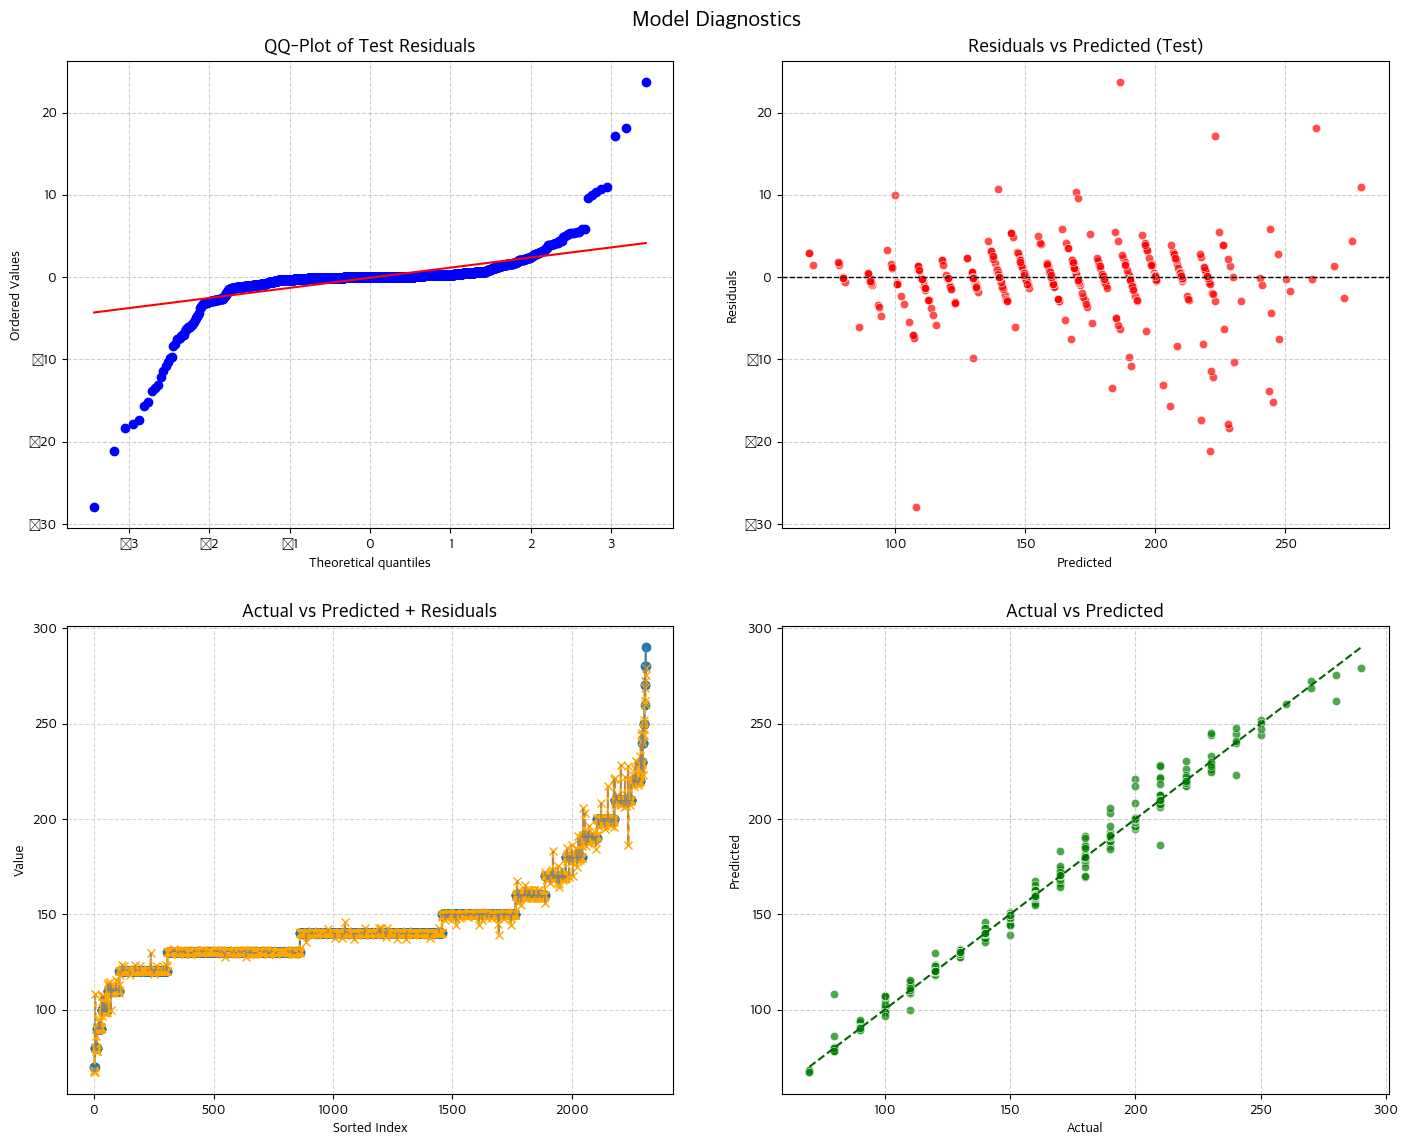

[I 2025-10-28 14:53:27,661] A new study created in memory with name: no-name-93719573-26a7-4b75-a3c3-ec31cb1a18ad


Train Accuracy
Train RMSE : 1.051
Train R2   : 0.999
Train SMAPE : 0.30
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.881
Test R2   : 0.995
Test SMAPE : 0.41
학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 4713


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:53:30,893] Trial 0 finished with value: 8.643612860568984 and parameters: {'n_estimators': 2823, 'max_depth': 9, 'learning_rate': 0.03171711019078264, 'subsample': 0.9722602054405416, 'gamma': 0.030179818644883227, 'reg_lambda': 0.05970101658911}. Best is trial 0 with value: 8.643612860568984.
[I 2025-10-28 14:53:32,449] Trial 1 finished with value: 8.691795584244053 and parameters: {'n_estimators': 1953, 'max_depth': 8, 'learning_rate': 0.06769491979640406, 'subsample': 0.9138607482400858, 'gamma': 0.4311248789555215, 'reg_lambda': 0.022224709000396393}. Best is trial 0 with value: 8.643612860568984.
[I 2025-10-28 14:53:33,237] Trial 2 finished with value: 9.295822765228227 and parameters: {'n_estimators': 815, 'max_depth': 6, 'learning_rate': 0.22436553221513283, 'subsample': 0.747972288639582, 'gamma': 0.19987983985291247, 'reg_lambda': 0.9918438283159485}. Best is trial 0 with value: 8.643612860568984.
[I 2025-10-28 14:53:38,515] Trial 3 finished with value: 8.5805

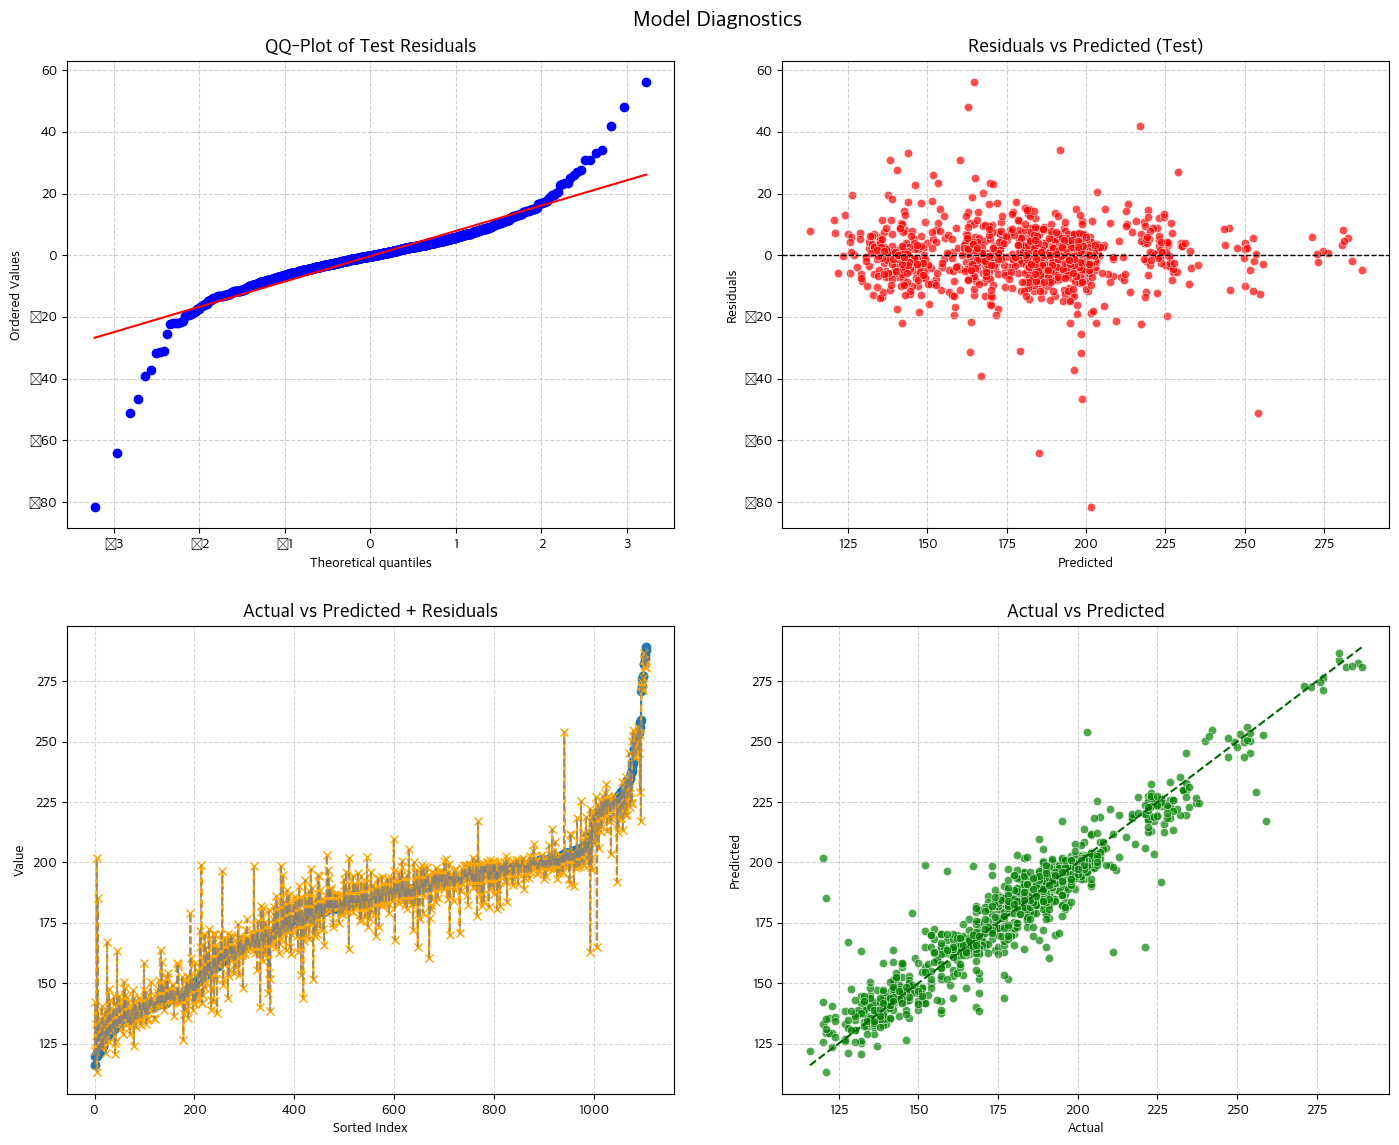

[I 2025-10-28 14:53:56,250] A new study created in memory with name: no-name-f4ceae34-8c13-4bdc-b4e6-4991a769a67b


Train Accuracy
Train RMSE : 1.485
Train R2   : 0.997
Train SMAPE : 0.61
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 8.813
Test R2   : 0.907
Test SMAPE : 3.27
학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 9851


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:54:00,167] Trial 0 finished with value: 30.41821215160165 and parameters: {'n_estimators': 854, 'max_depth': 10, 'learning_rate': 0.0023162786846688387, 'subsample': 0.7064959368040824, 'gamma': 0.22736236087551964, 'reg_lambda': 0.0063736341383394575}. Best is trial 0 with value: 30.41821215160165.
[I 2025-10-28 14:54:02,464] Trial 1 finished with value: 27.432475917786594 and parameters: {'n_estimators': 2881, 'max_depth': 12, 'learning_rate': 0.16552895794894748, 'subsample': 0.9361859313177867, 'gamma': 0.2567908055709541, 'reg_lambda': 0.7541023228276141}. Best is trial 1 with value: 27.432475917786594.
[I 2025-10-28 14:54:05,462] Trial 2 finished with value: 25.579029715917336 and parameters: {'n_estimators': 1580, 'max_depth': 12, 'learning_rate': 0.07121746470976295, 'subsample': 0.7166511671866712, 'gamma': 0.06357578194518765, 'reg_lambda': 0.05118778604711032}. Best is trial 2 with value: 25.579029715917336.
[I 2025-10-28 14:54:07,754] Trial 3 finished with 

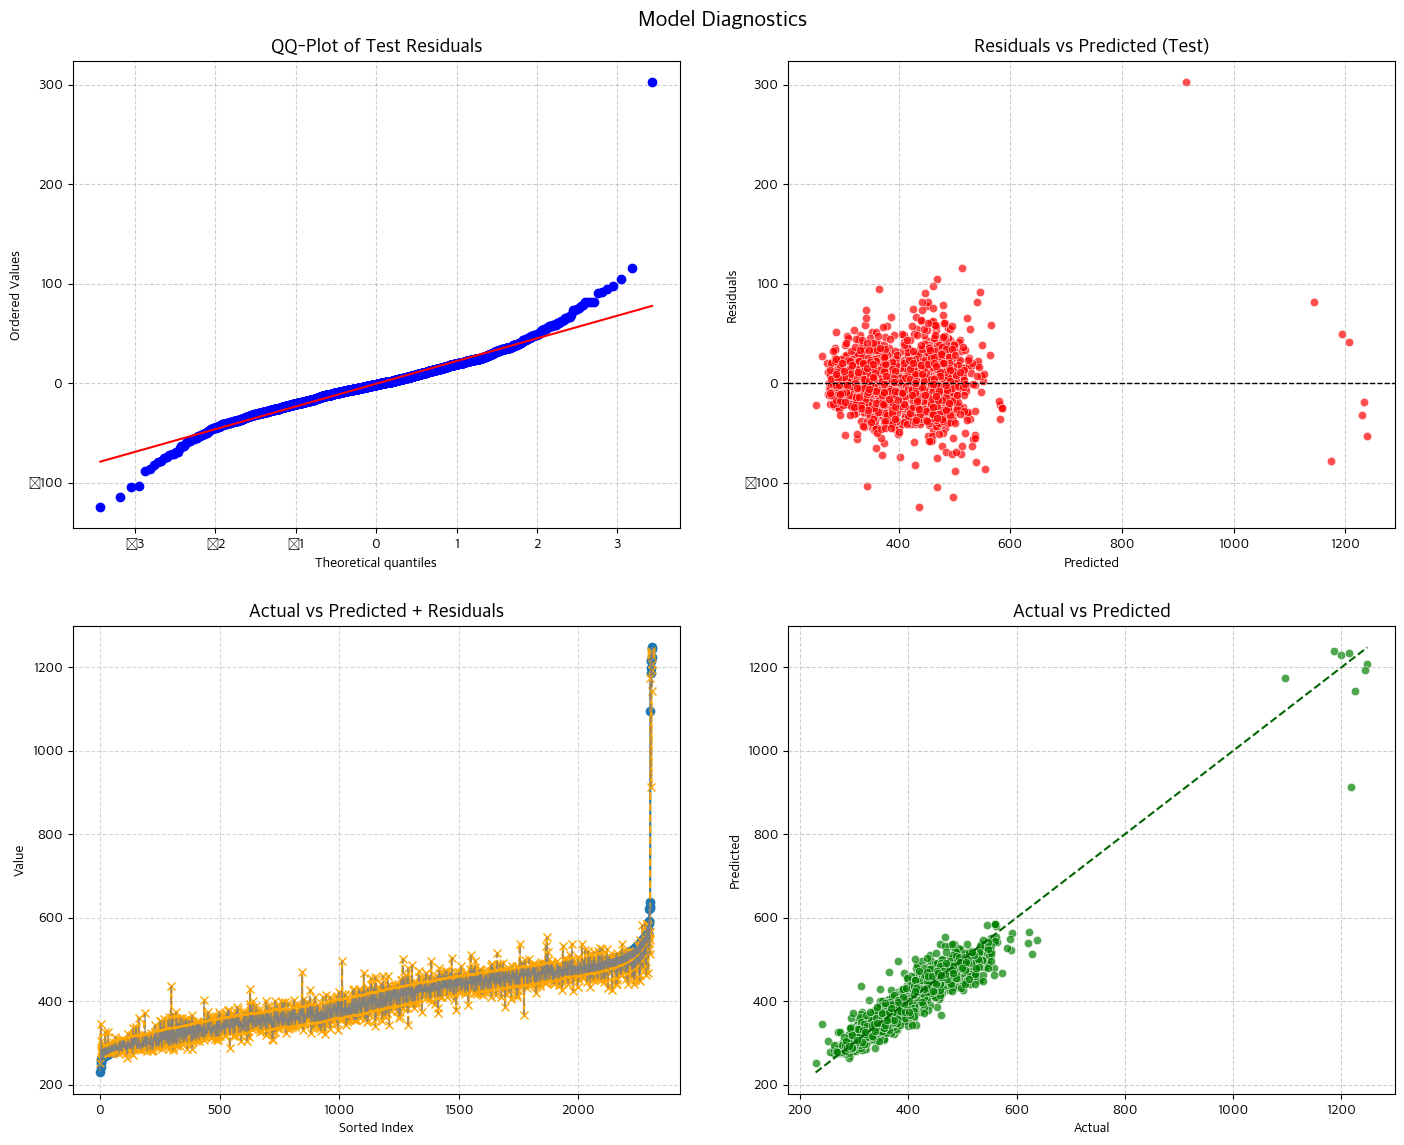

[I 2025-10-28 14:54:44,131] A new study created in memory with name: no-name-5d691b47-8cec-4068-8454-9e506df11a77


Train Accuracy
Train RMSE : 0.132
Train R2   : 1.000
Train SMAPE : 0.03
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 23.592
Test R2   : 0.923
Test SMAPE : 4.18
학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 9851


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:54:46,936] Trial 0 finished with value: 1.6419891388259333 and parameters: {'n_estimators': 2995, 'max_depth': 12, 'learning_rate': 0.055450449839650966, 'subsample': 0.9710179949143434, 'gamma': 0.12749219353390384, 'reg_lambda': 0.0023180487410336837}. Best is trial 0 with value: 1.6419891388259333.
[I 2025-10-28 14:54:48,569] Trial 1 finished with value: 1.6465311765646817 and parameters: {'n_estimators': 2304, 'max_depth': 12, 'learning_rate': 0.19566606289459026, 'subsample': 0.823573175588382, 'gamma': 0.2388396258984935, 'reg_lambda': 0.019577374380002458}. Best is trial 0 with value: 1.6419891388259333.
[I 2025-10-28 14:54:52,367] Trial 2 finished with value: 1.5099498568224188 and parameters: {'n_estimators': 2772, 'max_depth': 6, 'learning_rate': 0.02346150194319124, 'subsample': 0.7205228450773796, 'gamma': 0.35760226923896477, 'reg_lambda': 0.09843820192805187}. Best is trial 2 with value: 1.5099498568224188.
[I 2025-10-28 14:54:54,961] Trial 3 finished wit

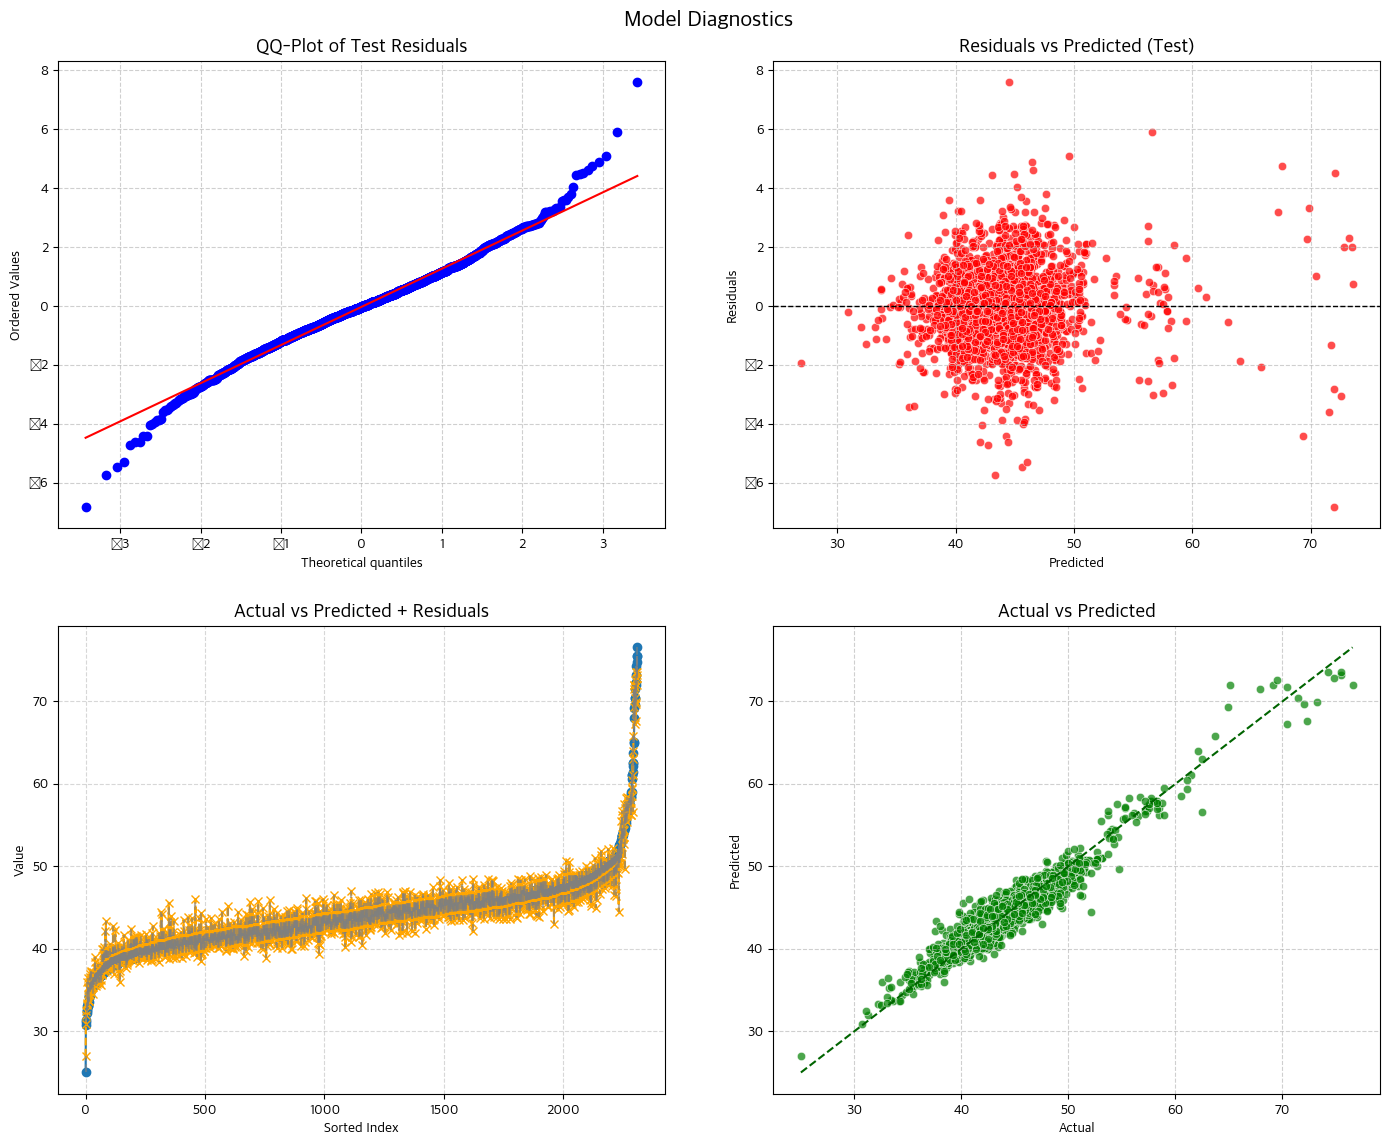

[I 2025-10-28 14:55:19,314] A new study created in memory with name: no-name-67556d80-81ca-4080-9a8e-ed4766c9a77f


Train Accuracy
Train RMSE : 0.386
Train R2   : 0.992
Train SMAPE : 0.69
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.303
Test R2   : 0.921
Test SMAPE : 2.23
학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 5849


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:55:20,700] Trial 0 finished with value: 1.2454417688638786 and parameters: {'n_estimators': 1491, 'max_depth': 10, 'learning_rate': 0.031762798066707155, 'subsample': 0.864506782316383, 'gamma': 0.4502383636703329, 'reg_lambda': 0.06705250527273107}. Best is trial 0 with value: 1.2454417688638786.
[I 2025-10-28 14:55:22,105] Trial 1 finished with value: 1.3140026923356534 and parameters: {'n_estimators': 1781, 'max_depth': 11, 'learning_rate': 0.27708267950226245, 'subsample': 0.7624621921884649, 'gamma': 0.00061654678403672, 'reg_lambda': 0.17886265131831894}. Best is trial 0 with value: 1.2454417688638786.
[I 2025-10-28 14:55:25,527] Trial 2 finished with value: 1.2377610096290557 and parameters: {'n_estimators': 2528, 'max_depth': 12, 'learning_rate': 0.010466026119422312, 'subsample': 0.7730327146505469, 'gamma': 0.38915107257384823, 'reg_lambda': 0.0023425831271075962}. Best is trial 2 with value: 1.2377610096290557.
[I 2025-10-28 14:55:35,735] Trial 3 finished wi

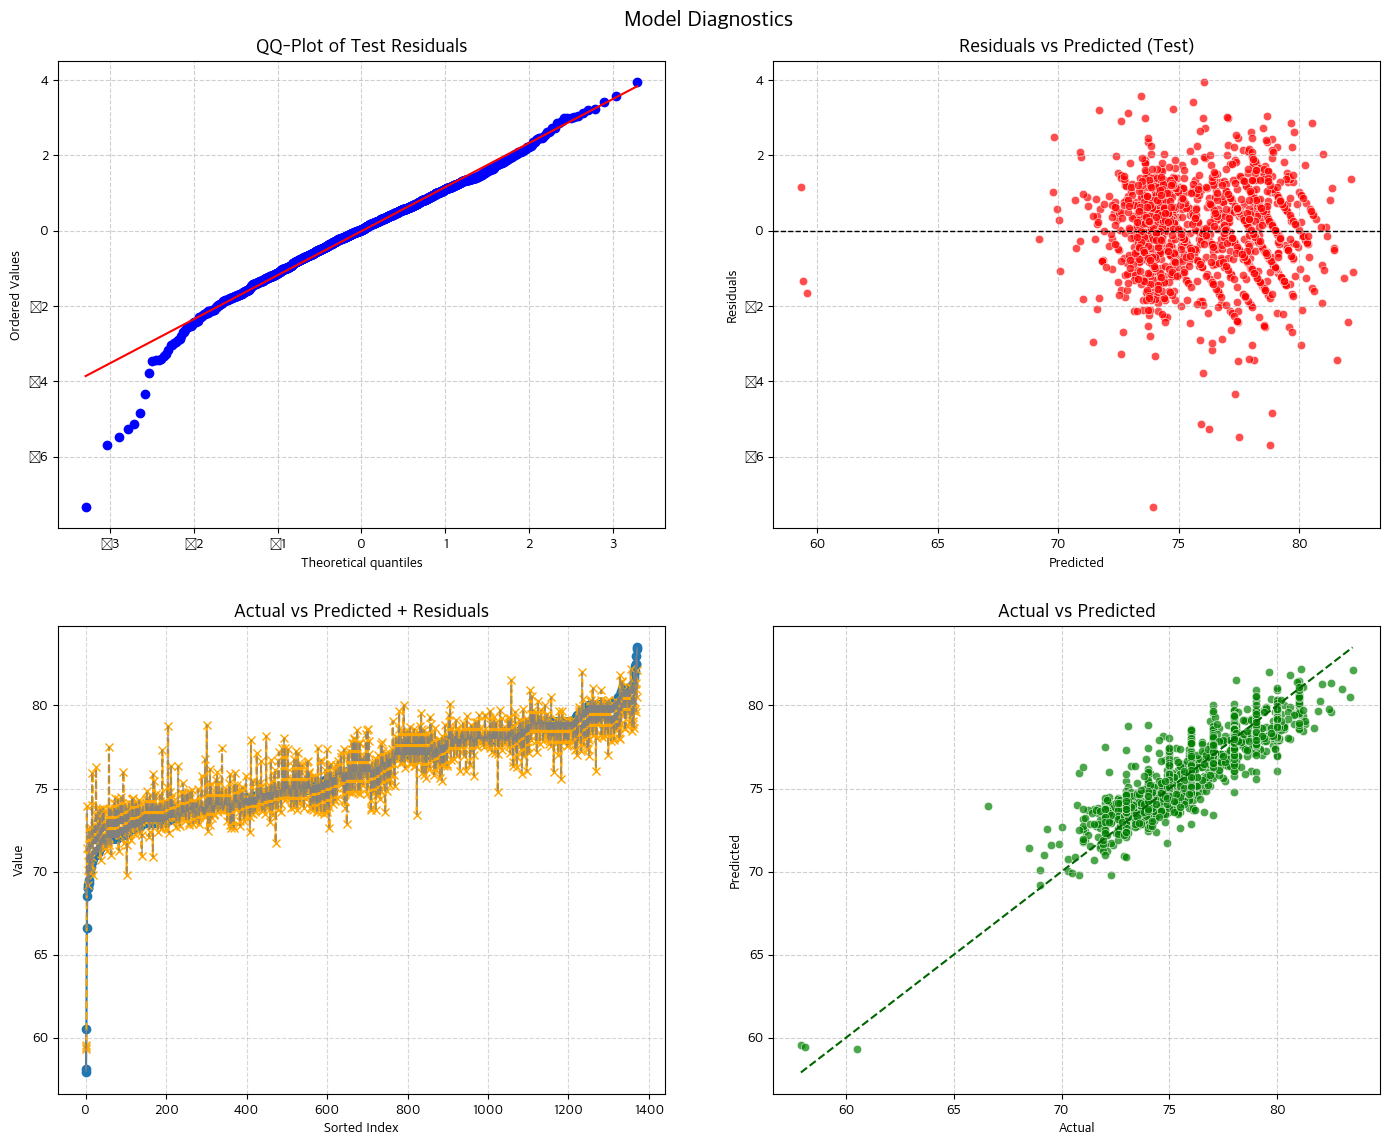

Train Accuracy
Train RMSE : 0.313
Train R2   : 0.986
Train SMAPE : 0.33
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.183
Test R2   : 0.814
Test SMAPE : 1.19


In [11]:
### Modelling 
# Cycle Time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# CT90 
ct_model, ct_importance = train_tree(ct_train_dataset, ct_test_dataset, target_col='Ct 90_결과')

# Scorch 
sc_model, sc_importance = train_tree(sc_train_dataset, sc_test_dataset, target_col='Scorch_결과')

# Vm 
vm_model, vm_importance = train_tree(vm_train_dataset, vm_test_dataset, target_col='Vm_결과')

# Hard 
hard_model, hard_importance = train_tree(hard_train_dataset, hard_test_dataset, target_col='경도_결과') 